In [322]:
import pandas as pd
import numpy as np
import re
from config import *

# Sklearn
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import umap

# Visual
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

In [323]:
sig_features = ['ANTI_SACCADE_total_acceleration_magnitude_right_max',
 'ANTI_SACCADE_total_acceleration_magnitude_right_median',
 'FITTS_LAW_avg_fixations_pr_second',
 'FITTS_LAW_std_fixations_pr_second',
 'FITTS_LAW_mean_amplitude_sacc',
 'FITTS_LAW_mean_duration_sacc',
 'FITTS_LAW_mean_duration_fix',
 'FITTS_LAW_total_acceleration_magnitude_right_mean',
 'FITTS_LAW_total_acceleration_magnitude_right_median',
 'REACTION_reaction_time_avg',
 'REACTION_reaction_time_std',
 'REACTION_total_acceleration_magnitude_right_median',
 'EVIL_BASTARD_mean_duration_sacc',
 'EVIL_BASTARD_total_acceleration_magnitude_right_max',
 'EVIL_BASTARD_total_acceleration_magnitude_right_median',
 'EVIL_BASTARD_distance_to_fixpoint_max',
 'SHAPES_total_acceleration_magnitude_right_mean',
 'SHAPES_total_acceleration_magnitude_right_median',
 'SMOOTH_PURSUITS_mean_peak_velocity_sacc',
 'SMOOTH_PURSUITS_mean_duration_sacc',
 'SMOOTH_PURSUITS_total_acceleration_magnitude_right_max',
 'SMOOTH_PURSUITS_total_acceleration_magnitude_right_median',
 'SMOOTH_PURSUITS_Var_total',
 'SMOOTH_PURSUITS_distance_to_fixpoint_max',
 'SMOOTH_PURSUITS_distance_to_fixpoint_std']

data = pd.read_parquet(FEATURES_DIR / "features.pq").dropna()
data = data.query("y==1")
y = data["y"]

X = data.drop(["participant_id", "y"] ,axis=1)
cols = X.columns
# X = data[sig_features]
X = StandardScaler().fit_transform(X)


In [324]:
# Dicts to save WCSS and BCSS
silhouette_scores = {"n_clusters" : [], "Silhouette score" : []}
cluster_purity = {"n_clusters" : [], "Cluster purity" : []}

n_splits=5
skf = StratifiedKFold(n_splits=n_splits)

for n_clusters in range(2,11):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage="ward")
    model.fit(X)

    # Compute silhouette score
    sil_score = silhouette_score(X, model.labels_)

    # Compute Purity Score (how well clusters match patient/control labels)
    contingency_matrix = np.zeros((n_clusters, 2))  # Assuming two classes (patients & controls)
    for k in range(n_clusters):
        if np.any(model.labels_ == k):
            contingency_matrix[k, 0] = np.sum((model.labels_ == k) & (y == 0))  # Controls
            contingency_matrix[k, 1] = np.sum((model.labels_ == k) & (y == 1))  # Patients
    cps_score = np.sum(np.max(contingency_matrix, axis=1)) / np.sum(contingency_matrix)

    silhouette_scores["n_clusters"].append(n_clusters)
    silhouette_scores["Silhouette score"].append(sil_score)

    cluster_purity["n_clusters"].append(n_clusters)
    cluster_purity["Cluster purity"].append(cps_score)

<Axes: xlabel='n_clusters', ylabel='Silhouette score'>

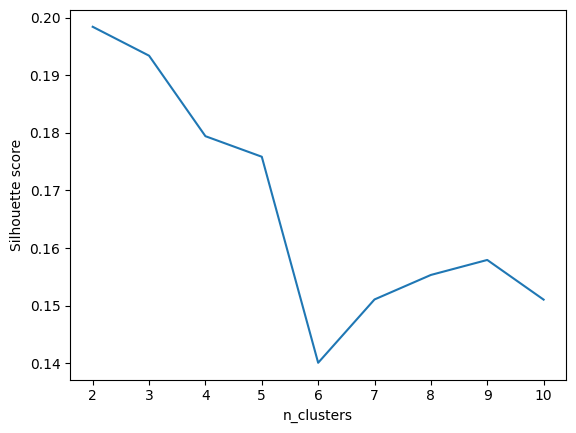

In [325]:
silhouette_score_df = pd.DataFrame.from_dict(silhouette_scores)

sns.lineplot(data = silhouette_score_df, x="n_clusters", y="Silhouette score")

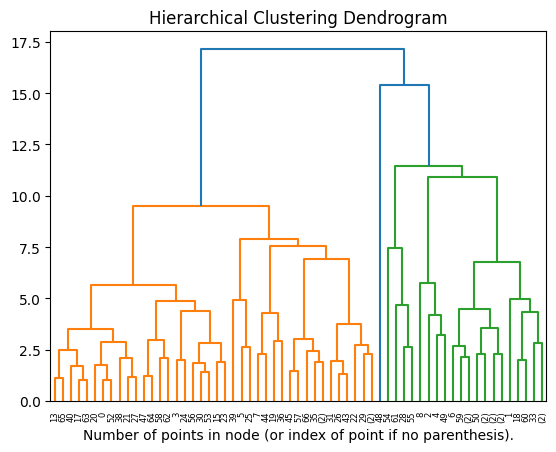

In [326]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)


model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=7)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


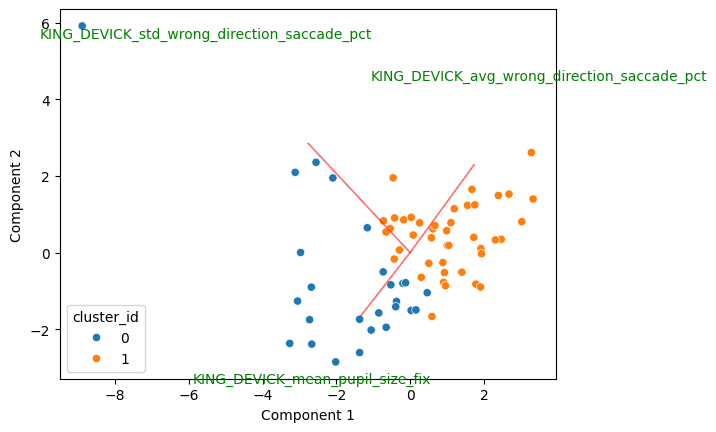

In [327]:

def plot_reduction_with_clusters(X_reduced, clusters, coeff = None, labels=None):
    X_reduced_df = pd.DataFrame({'Component 1': X_reduced[:,0], 'Component 2': X_reduced[:,1]})
    X_reduced_df["cluster_id"] = clusters
    sns.scatterplot(X_reduced_df, x='Component 1', y='Component 2', hue='cluster_id')
    if coeff is not None:
        n = coeff.shape[0]
        for i in range(n):
            if np.abs(coeff[i,0]) > 0.15 and np.abs(coeff[i,1]) > 0.15:
                plt.arrow(0, 0, coeff[i,0]*5, coeff[i,1]*5,color = 'r',alpha = 0.5)
                if labels is None:
                    plt.text(coeff[i,0]* 10, coeff[i,1] * 10, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
                else:
                    plt.text(coeff[i,0]* 10, coeff[i,1] * 10, labels[i], color = 'g', ha = 'center', va = 'center')

clustering_model = AgglomerativeClustering(n_clusters=2, distance_threshold=None).fit(X)
# clustering_model = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X)
# clustering_model = DBSCAN(eps=0.91, min_samples=5).fit(X)

# reducer = umap.UMAP(random_state=42)

# reducer = TSNE(random_state=42)

reducer = PCA()

X_reduced = reducer.fit_transform(X)
components = reducer.components_

clusters = clustering_model.labels_
plot_reduction_with_clusters(X_reduced, clusters, components, labels=cols)